In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import libraries
import torch
import torch.nn as nn
import scipy.stats as stats
import matplotlib.pyplot as plt
from IPython import display
import pandas as pd
import numpy as np
import seaborn as sns
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset
display.set_matplotlib_formats('svg')

In [ ]:
data = pd.read_csv("PATH/ml_sample4.csv")
# data.head()
new_data = data.sample(frac=1).reset_index(drop=True)
# new_data=pd.concat([data[data["class"]==1],data[data["class"]==0].sample(8092)]);
# new_data.head()
# new_data = new_data.sample(frac=1).reset_index(drop=True)
# new_data.shape
# new_data.url = new_data.url.fillna(0)
new_data.isna().any()

location                              False
description                           False
url                                   False
followers_count                       False
friends_count                         False
listed_count                          False
favourites_count                      False
geo_enabled                           False
verified                              False
statuses_count                        False
profile_background_image_url_https    False
profile_background_tile               False
profile_image_url                     False
profile_use_background_image          False
has_extended_profile                  False
default_profile                       False
default_profile_image                 False
profile_banner_url                    False
entities.url.urls                     False
class                                 False
dtype: bool

# Import and process the data

In [ ]:
labels = torch.tensor( new_data['class'] ).long()
new_data=new_data.drop(['class'],axis=1) 

# data.loc[:, data.columns != 'class'].apply(stats.zscore)
new_data=new_data.apply(stats.zscore);
sample = torch.tensor(new_data.values).float()


In [ ]:
# check the distributions again
fig,ax = plt.subplots(1,figsize=(17,4))
ax = sns.boxplot(data=sample)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()

In [ ]:
train_data,test_data, train_labels,test_labels = train_test_split(sample, labels, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
# train_dataDataset = TensorDataset(train_data,train_labels)
# test_dataDataset  = TensorDataset(test_data,test_labels)


# train and test dataloaders
# test_loader  = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])
# train_loader = DataLoader(train_dataDataset,batch_size=64, shuffle=True, drop_last=True)

# Create the ANN model

In [ ]:
# create a class for the model

class ANN_CLASS_MODEL(nn.Module):
  def __init__(self,nUnits,nLayers,dropoutRate):
    super().__init__()

    # create dictionary to store the layers
    self.layers = nn.ModuleDict()
    self.nLayers = nLayers
    self.dr = dropoutRate

    ### input layer
    self.layers['input'] = nn.Linear(19,nUnits)
    
    ### hidden layers
    for i in range(nLayers):
      self.layers[f'hidden{i}'] = nn.Linear(nUnits,nUnits)
      self.layers[f'batch{i}'] = nn.BatchNorm1d(nUnits)


    ### output layer
    self.layers['output'] = nn.Linear(nUnits,2)
  

  # forward pass
  def forward(self,x,useBatchLayer=True):
    # input layer
    x = F.relu(self.layers['input'](x))
    x = F.dropout(x,p=self.dr,training=self.training) # switch dropout off during .eval()


    # hidden layers
    for i in range(self.nLayers):
      if useBatchLayer:
        x = F.relu(self.layers[f'batch{i}'](self.layers[f'hidden{i}'](x)))
      else:
        x = F.relu(self.layers[f'hidden{i}'](x))
        x = F.dropout(x,p=self.dr,training=self.training)


    return self.layers['output'](x)

In [ ]:
ml_model = ANN_CLASS_MODEL(64,2,.20)
ml_model

ANN_CLASS_MODEL(
  (layers): ModuleDict(
    (input): Linear(in_features=19, out_features=64, bias=True)
    (hidden0): Linear(in_features=64, out_features=64, bias=True)
    (batch0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (hidden1): Linear(in_features=64, out_features=64, bias=True)
    (batch1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (output): Linear(in_features=64, out_features=2, bias=True)
  )
)

# Train the model

In [ ]:
print(train_data.shape)
print(train_labels.shape)

torch.Size([11944, 19])
torch.Size([11944])


In [ ]:
numepochs = 500

# initialize losses
losses = torch.zeros(numepochs)
ongoingAcc = []
ongoingAcc_test = []

lossfun = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ml_model.parameters(),lr=0.01)


# loop over epochs
for epochi in range(numepochs):

  # forward pass
  yHat = ml_model(train_data)
  loss = lossfun(yHat,train_labels)
  losses[epochi] = loss

  # backprop
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  matches = torch.argmax(yHat,axis=1) == train_labels 
  matchesNumeric = matches.float()            
  ongoingAcc.append( 100*torch.mean(matchesNumeric))
  ongoingAcc_test.append(100*torch.mean((torch.argmax(ml_model(test_data),axis=1) == test_labels).float()))


predictions = ml_model(train_data)
predlabels = torch.argmax(predictions,axis=1)
totalacc = 100*torch.mean((predlabels == train_labels).float())

predictions_test = ml_model(test_data)
predlabels_test = torch.argmax(predictions_test,axis=1)
totalacc_test = 100*torch.mean((predlabels_test == test_labels).float())

Train accuracy: 84.8208%
Test accuracy: 79.5181%
Train Data Shape: torch.Size([11944, 19])
Train label Shape: torch.Size([11944])
Test Data Shape: torch.Size([1328, 19])
Test label Shape: torch.Size([1328])


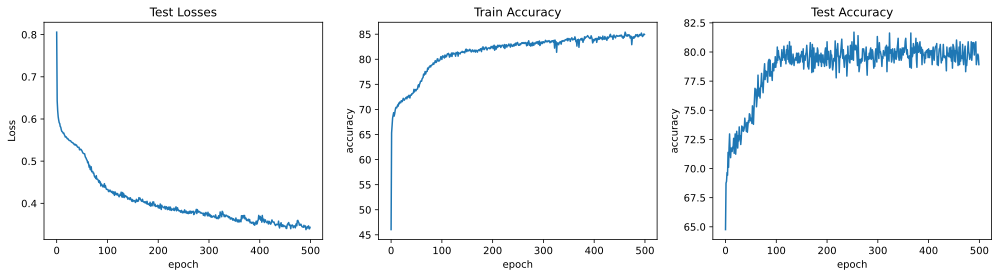

In [ ]:
# report accuracy
print('Train accuracy: %g%%' %totalacc)
print('Test accuracy: %g%%' %totalacc_test)
print(f'Train Data Shape: {train_data.shape}')
print(f'Train label Shape: {train_labels.shape}')
print(f'Test Data Shape: {test_data.shape}')
print(f'Test label Shape: {test_labels.shape}')

fig,ax = plt.subplots(1,3,figsize=(17,4))

ax[0].plot(losses.detach())
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('epoch')
ax[0].set_title('Test Losses')

ax[1].plot(ongoingAcc)
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('epoch')
ax[1].set_title('Train Accuracy')

ax[2].plot(ongoingAcc_test)
ax[2].set_ylabel('accuracy')
ax[2].set_xlabel('epoch')
ax[2].set_title('Test Accuracy')
plt.show()

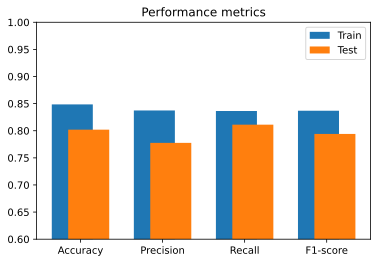

In [ ]:
import sklearn.metrics as skm

# initialize vectors
train_metrics = [0,0,0,0]
test_metrics  = [0,0,0,0]

predlabels = torch.argmax(ml_model(train_data),axis=1)


testlabels = torch.argmax(ml_model(test_data),axis=1)


train_metrics[0] = skm.accuracy_score (train_labels,predlabels)
train_metrics[1] = skm.precision_score(train_labels,predlabels)
train_metrics[2] = skm.recall_score   (train_labels,predlabels)
train_metrics[3] = skm.f1_score       (train_labels,predlabels)


test_metrics[0] = skm.accuracy_score (test_labels,testlabels)
test_metrics[1] = skm.precision_score(test_labels,testlabels)
test_metrics[2] = skm.recall_score   (test_labels,testlabels)
test_metrics[3] = skm.f1_score       (test_labels,testlabels)

plt.bar(np.arange(4)-.1,train_metrics,.5)
plt.bar(np.arange(4)+.1,test_metrics,.5)
plt.xticks([0,1,2,3],['Accuracy','Precision','Recall','F1-score'])
plt.ylim([.6,1])
plt.legend(['Train','Test'])
plt.title('Performance metrics')
plt.show()

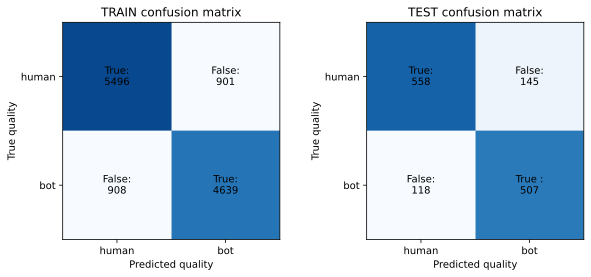

array([[5496,  901],
       [ 908, 4639]])

In [ ]:
# Confusion matrices
trainConf = skm.confusion_matrix(train_labels,predlabels)
testConf  = skm.confusion_matrix(test_labels,testlabels)

fig,ax = plt.subplots(1,2,figsize=(10,4))

# confmat during TRAIN
ax[0].imshow(trainConf,'Blues',vmax=len(predlabels)/2)
ax[0].set_xticks([0,1])
ax[0].set_yticks([0,1])
ax[0].set_xticklabels(['human','bot'])
ax[0].set_yticklabels(['human','bot'])
ax[0].set_xlabel('Predicted quality')
ax[0].set_ylabel('True quality')
ax[0].set_title('TRAIN confusion matrix')

# add text labels
ax[0].text(0,0,f'True:\n{trainConf[0,0]}' ,ha='center',va='center')
ax[0].text(0,1,f'False:\n{trainConf[1,0]}',ha='center',va='center')
ax[0].text(1,1,f'True:\n{trainConf[1,1]}' ,ha='center',va='center')
ax[0].text(1,0,f'False:\n{trainConf[0,1]}',ha='center',va='center')




# confmat during TEST
ax[1].imshow(testConf,'Blues',vmax=len(testlabels)/2)
ax[1].set_xticks([0,1])
ax[1].set_yticks([0,1])
ax[1].set_xticklabels(['human','bot'])
ax[1].set_yticklabels(['human','bot'])
ax[1].set_xlabel('Predicted quality')
ax[1].set_ylabel('True quality')
ax[1].set_title('TEST confusion matrix')

# add text labels
ax[1].text(0,0,f'True:\n{testConf[0,0]}' ,ha='center',va='center')
ax[1].text(0,1,f'False:\n{testConf[1,0]}',ha='center',va='center')
ax[1].text(1,1,f'True :\n{testConf[1,1]}' ,ha='center',va='center')
ax[1].text(1,0,f'False:\n{testConf[0,1]}',ha='center',va='center')
plt.show()

trainConf